In [1]:
import sys
print(sys.prefix)

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg


In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import metcalc
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
from sklearn.feature_selection import mutual_info_regression
import glob
import dask
import copy

2022.3.0


In [2]:
def read_sims(name,GCM,reference_dataset,epsilons=[0,0.01,0.02,0.05,0.1,0.2,0.3,0.5,0.7,1,1.5,2],f="gill",res=2) :
    sims_list = []
        
    for ep in epsilons :
        sims_ev_list = []
        for ev in epsilons :
            full_name = name + f"epsilon_p={ep}_epsilon_u={ev}_epsilon_v={ev}_f={f}_res={res}.nc"
            if os.path.isfile(full_name) :
                sims_ev_list.append(xr.open_dataset(full_name))
            else :
                sims_ev_list.append(xr.full_like(reference_dataset,np.NaN))
        
        sims_list.append(xr.concat(sims_ev_list,xr.DataArray(epsilons,coords=[epsilons], dims=["epsilon_wind"])))
        
    all_sims = xr.concat(sims_list,xr.DataArray(epsilons,coords=[epsilons], dims=["epsilon_pre"]))

    # - select 20N-20S
    # - get rid of boundaries... (1sr and last index)

    sims_20 = all_sims.isel(x=slice(1,-1),y=slice(6,26)) # for 2x2 res
        
    GCM_20 = GCM.sel(lat=slice(-20,20))
    sims_20 = sims_20.assign_coords(lon = ("x", GCM_20.lon.values)).assign_coords(lat = ("y", GCM_20.lat.values))
    sims_20 = sims_20.swap_dims({"x": "lon"}).swap_dims({"y": "lat"})
    return sims_20
                             

In [3]:
def read_sims_ZC(name,GCM,reference_dataset,epsilons=[0,0.01,0.02,0.05,0.1,0.2,0.3,0.5,0.7,1,1.5,2],f="gill",res=2) :
    sims_list = []
    ep=0
    sims_ev_list = []
    
    for ev in epsilons :
        full_name = name + f"epsilon_p={ep}_epsilon_u={ev}_epsilon_v={ev}_f={f}_res={res}.nc"
        if os.path.isfile(full_name) :
            sims_ev_list.append(xr.open_dataset(full_name))
        else :
            sims_ev_list.append(xr.full_like(reference_dataset,np.NaN))
    all_sims = xr.concat(sims_ev_list,xr.DataArray(epsilons,coords=[epsilons], dims=["epsilon_wind"]))

    # - select 20N-20S
    # - get rid of boundaries... (1sr and last index)

    sims_20 = all_sims.isel(x=slice(1,-1),y=slice(6,26)) # for 2x2 res
        
    GCM_20 = GCM.sel(lat=slice(-20,20))
    sims_20 = sims_20.assign_coords(lon = ("x", GCM_20.lon.values)).assign_coords(lat = ("y", GCM_20.lat.values))
    sims_20 = sims_20.swap_dims({"x": "lon"}).swap_dims({"y": "lat"})
    return sims_20
                             

In [4]:
def correlations(sim_an,GCM_diff_an,corr_lat1=-20,corr_lat2=10) :
            
    sim_stacked = sim_an.sel(lat=slice(corr_lat1,corr_lat2)).stack(coord=("lon", "lat"))
    GCM_diff_an_stacked = GCM_diff_an.sel(lat=slice(corr_lat1,corr_lat2)).stack(coord=("lon", "lat"))
    
    corr = xr.corr(sim_stacked.p,GCM_diff_an_stacked["700_200_thick"],dim="coord").to_dataset(name="700_200_thick")
    corr["400_200_thick"] = xr.corr(sim_stacked.p,GCM_diff_an_stacked["400_200_thick"],dim="coord")
    corr["400_150_thick"] = xr.corr(sim_stacked.p,GCM_diff_an_stacked["400_150_thick"],dim="coord")
    corr["500_150_thick"] = xr.corr(sim_stacked.p,GCM_diff_an_stacked["500_150_thick"],dim="coord")
    corr["700_150_thick"] = xr.corr(sim_stacked.p,GCM_diff_an_stacked["700_150_thick"],dim="coord")
    corr["700_400_thick"] = xr.corr(sim_stacked.p,GCM_diff_an_stacked["700_400_thick"],dim="coord")

    return corr


In [5]:
def calc_MI(sim_an,GCM_diff_an,corr_lat1=-20,corr_lat2=10,warning=False) :
    
    p_corr = sim_an["p"].sel(lat=slice(corr_lat1,corr_lat2)).stack(coord=("lat", "lon")).chunk({"model_id" : 2})
    GCM_corr_400_150 = GCM_diff_an["400_150_thick"].sel(lat=slice(corr_lat1,corr_lat2)).stack(coord=("lat", "lon")).chunk({"model_id" : 2})
    GCM_corr_400_200 = GCM_diff_an["400_200_thick"].sel(lat=slice(corr_lat1,corr_lat2)).stack(coord=("lat", "lon")).chunk({"model_id" : 2})
    GCM_corr_700_200 = GCM_diff_an["700_200_thick"].sel(lat=slice(corr_lat1,corr_lat2)).stack(coord=("lat", "lon")).chunk({"model_id" : 2})
    
    MI = metcalc.xr_MI(p_corr,GCM_corr_400_150,"coord").to_dataset(name="400_150_thick")
    MI["400_200_thick"] = metcalc.xr_MI(p_corr,GCM_corr_400_200,"coord")
    MI["700_200_thick"] = metcalc.xr_MI(p_corr,GCM_corr_700_200,"coord")

    return MI


In [6]:
def preproc(ds):
    if 'plev' in ds.coords :
        ds.coords['plev2'] = ds.plev / 100
        ds = ds.swap_dims({'plev': 'plev2'})
        ds.plev2['units'] = 'hPa'
    return ds

# Read data

In [ ]:
WORK_DIR="/work/mh0066/m300577/cmip6/ssp585"
GILL_DIR="/work/mh0066/m300577/numerical_gill/data"

In [7]:
cmip6_ta = xr.open_mfdataset(f"{WORK_DIR}/ta/ta_ssp585_*_mm_global2x2.nc",concat_dim="model_id", combine='nested',preprocess=preproc).drop_sel(model_id=["ACCESS-ESM1-5","CIESM"])
cmip6_ta["hus"] = xr.open_mfdataset(f"{WORK_DIR}/hus/hus_ssp585_*_mm_global2x2.nc",concat_dim="model_id", combine='nested',preprocess=preproc).drop_sel(model_id=["ACCESS-ESM1-5","CIESM"]).hus
cmip6_ta = cmip6_ta.chunk({"plev2":1})

In [8]:
%%time

cmip6_ta["Tv"] = metcalc.virtual_temperature(cmip6_ta.ta,cmip6_ta.hus)

cmip6_ta["700_200_thick"] = metcalc.xr_thickness(cmip6_ta.Tv,700,200)
cmip6_ta["700_400_thick"] = metcalc.xr_thickness(cmip6_ta.Tv,700,400)
cmip6_ta["400_200_thick"] = metcalc.xr_thickness(cmip6_ta.Tv,400,200)
cmip6_ta["400_150_thick"] = metcalc.xr_thickness(cmip6_ta.Tv,400,150)
cmip6_ta["500_150_thick"] = metcalc.xr_thickness(cmip6_ta.Tv,500,150)
cmip6_ta["700_150_thick"] = metcalc.xr_thickness(cmip6_ta.Tv,700,150)
cmip6_ta["Phi"] = metcalc.xr_geopotential(cmip6_ta.ta).Phi

with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    cmip6_early = cmip6_ta.sel(time=slice('2015-01-31','2034-12-31')).groupby("time.season").mean("time").compute()
    cmip6_late = cmip6_ta.sel(time=slice('2080-01-31','2099-12-31')).groupby("time.season").mean("time").compute()

cmip6_diff = cmip6_late - cmip6_early

CPU times: user 12min 48s, sys: 20min 44s, total: 33min 32s
Wall time: 4min 17s


In [9]:
epsilons = [0.0,0.01,0.02,0.05,0.1,0.2,0.3,0.5,0.7,1.5]

In [10]:
def preproc_modelid(ds):
    ds.coords["model_id"] = ds.p.model_id
    return ds

all_models = xr.open_mfdataset(f"{GILL_DIR}/sims_cmip_DJF_400-150_FFT/pr_late_non_dim_*_epsilon_p=1.0_epsilon_u=1.0_epsilon_v=1.0_f=gill_res=2.nc"
                              ,concat_dim="model_id", combine='nested',preprocess=preproc_modelid).model_id                               

In [11]:
ref_d = xr.open_dataset(f"{GILL_DIR}/sims_cmip_DJF_400-150_FFT/pr_late_non_dim_ACCESS-CM2_30N-30S_DJF_400-150_epsilon_p=1.0_epsilon_u=1.0_epsilon_v=1.0_f=gill_res=2.nc")

In [12]:
sims_list_DJF = []
sims_list_JJA = []

for model in all_models :
    sims_list_DJF.append(read_sims(f"{GILL_DIR}/sims_cmip_DJF_400-150_FFT/pr_early_non_dim_{model.values}_30N-30S_DJF_400-150_",cmip6_early,ref_d,epsilons=epsilons))
    sims_list_JJA.append(read_sims(f"{GILL_DIR}/sims_cmip_JJA_400-150_FFT/pr_early_non_dim_{model.values}_30N-30S_JJA_400-150_",cmip6_early,ref_d,epsilons=epsilons))

sims_DJF_early = xr.concat(sims_list_DJF,all_models)
sims_JJA_early = xr.concat(sims_list_JJA,all_models)



In [13]:
sims_list_DJF = []
sims_list_JJA = []

for model in all_models :
    sims_list_DJF.append(read_sims_ZC(f"{GILL_DIR}/sims_cmip_DJF_400-150_zon_comp_FFT/pr_early_non_dim_{model.values}_30N-30S_DJF_400-150_zon_comp_",
                                      cmip6_early,ref_d,epsilons=epsilons))
    sims_list_JJA.append(read_sims_ZC(f"{GILL_DIR}/sims_cmip_JJA_400-150_zon_comp_FFT/pr_early_non_dim_{model.values}_30N-30S_JJA_400-150_zon_comp_",
                                         cmip6_early,ref_d,epsilons=epsilons))

sims_DJF_early_ZC = xr.concat(sims_list_DJF,all_models)
sims_JJA_early_ZC = xr.concat(sims_list_JJA,all_models)



In [14]:
sims_list_DJF = []
sims_list_JJA = []

for model in all_models :
    sims_list_DJF.append(read_sims(f"{GILL_DIR}/sims_cmip_DJF_400-150_FFT/pr_late_non_dim_{model.values}_30N-30S_DJF_400-150_",cmip6_early,ref_d,epsilons=epsilons))
    sims_list_JJA.append(read_sims(f"{GILL_DIR}/sims_cmip_JJA_400-150_FFT/pr_late_non_dim_{model.values}_30N-30S_JJA_400-150_",cmip6_early,ref_d,epsilons=epsilons))

sims_DJF_late = xr.concat(sims_list_DJF,all_models)
sims_JJA_late = xr.concat(sims_list_JJA,all_models)



In [15]:
sims_list_DJF = []
sims_list_JJA = []

for model in all_models :
    sims_list_DJF.append(read_sims_ZC(f"{GILL_DIR}/sims_cmip_DJF_400-150_zon_comp_FFT/pr_late_non_dim_{model.values}_30N-30S_DJF_400-150_zon_comp_",
                                      cmip6_early,ref_d,epsilons=epsilons))
    sims_list_JJA.append(read_sims_ZC(f"{GILL_DIR}/sims_cmip_DJF_400-150_zon_comp_FFT/pr_late_non_dim_{model.values}_30N-30S_JJA_400-150_zon_comp_",
                                         cmip6_early,ref_d,epsilons=epsilons))

sims_DJF_late_ZC = xr.concat(sims_list_DJF,all_models)
sims_JJA_late_ZC = xr.concat(sims_list_JJA,all_models)



In [16]:
sims_list_DJF = []
sims_list_JJA = []

for model in all_models :
    sims_list_DJF.append(read_sims(f"{GILL_DIR}/sims_cmip_DJF_400-150_FFT/delta_pr_non_dim_{model.values}_30N-30S_DJF_400-150_",cmip6_early,ref_d,epsilons=epsilons))
    sims_list_JJA.append(read_sims(f"{GILL_DIR}/sims_cmip_JJA_400-150_FFT/delta_pr_non_dim_{model.values}_30N-30S_JJA_400-150_",cmip6_early,ref_d,epsilons=epsilons))

sims_diff_DJF = xr.concat(sims_list_DJF,all_models)
sims_diff_JJA = xr.concat(sims_list_JJA,all_models)



In [17]:
sims_list_DJF = []
sims_list_JJA = []

for model in all_models :
    sims_list_DJF.append(read_sims_ZC(f"{GILL_DIR}/sims_cmip_DJF_400-150_zon_comp_FFT/delta_pr_non_dim_{model.values}_30N-30S_DJF_400-150_zon_comp_",
                                      cmip6_early,ref_d,epsilons=epsilons))
    sims_list_JJA.append(read_sims_ZC(f"{GILL_DIR}/sims_cmip_JJA_400-150_zon_comp_FFT/delta_pr_non_dim_{model.values}_30N-30S_JJA_400-150_zon_comp_",
                                         cmip6_early,ref_d,epsilons=epsilons))

sims_DJF_diff_ZC = xr.concat(sims_list_DJF,all_models)
sims_JJA_diff_ZC = xr.concat(sims_list_JJA,all_models)



In [18]:
sims_DJF_early_zc = copy.deepcopy(sims_DJF_early)
sims_JJA_early_zc = copy.deepcopy(sims_JJA_early)
sims_DJF_late_zc = copy.deepcopy(sims_DJF_late)
sims_JJA_late_zc = copy.deepcopy(sims_JJA_late)
sims_diff_DJF_zc = copy.deepcopy(sims_diff_DJF)
sims_diff_JJA_zc = copy.deepcopy(sims_diff_JJA)

In [19]:
sims_DJF_early_zc.loc[dict(epsilon_pre=0)] = sims_DJF_early_ZC
sims_JJA_early_zc.loc[dict(epsilon_pre=0)] = sims_JJA_early_ZC
sims_DJF_late_zc.loc[dict(epsilon_pre=0)] = sims_DJF_late_ZC
sims_JJA_late_zc.loc[dict(epsilon_pre=0)] = sims_JJA_late_ZC
sims_diff_DJF_zc.loc[dict(epsilon_pre=0)] = sims_DJF_diff_ZC
sims_diff_JJA_zc.loc[dict(epsilon_pre=0)] = sims_JJA_diff_ZC

# Calculate Correlations
It seems that the best correlation is achieved with the 400-150 hpa layer thickness, that is why we focus on this for now

We do not calculate random MI from surrogate (shuffled) data, becasue we have shown in the other scripts that all values are significant and it takes a lot of time

In [20]:
corrs_DJF_early = correlations(sims_DJF_early_zc,cmip6_early.sel(season="DJF"),corr_lat1=-20,corr_lat2=10).compute()
corrs_JJA_early = correlations(sims_JJA_early_zc,cmip6_early.sel(season="JJA"),corr_lat1=-10,corr_lat2=20).compute()

corrs_DJF_early_model_mean = corrs_DJF_early.mean("model_id")
corrs_JJA_early_model_mean = corrs_JJA_early.mean("model_id")


In [21]:
corrs_DJF_late = correlations(sims_DJF_late_zc,cmip6_late.sel(season="DJF"),corr_lat1=-20,corr_lat2=10).compute()
corrs_JJA_late = correlations(sims_JJA_late_zc,cmip6_late.sel(season="JJA"),corr_lat1=-10,corr_lat2=20).compute()

corrs_DJF_late_model_mean = corrs_DJF_late.mean("model_id")
corrs_JJA_late_model_mean = corrs_JJA_late.mean("model_id")


In [22]:
corrs_DJF_diff = correlations(sims_diff_DJF_zc,cmip6_diff.sel(season="DJF"),corr_lat1=-20,corr_lat2=10).compute()
corrs_JJA_diff = correlations(sims_diff_JJA_zc,cmip6_diff.sel(season="JJA"),corr_lat1=-10,corr_lat2=20).compute()

corrs_DJF_diff_model_mean = corrs_DJF_diff.mean("model_id")
corrs_JJA_diff_model_mean = corrs_JJA_diff.mean("model_id")


In [23]:
corrs_DJF_early_no_zc = correlations(sims_DJF_early,cmip6_early.sel(season="DJF"),corr_lat1=-20,corr_lat2=10).compute()
corrs_JJA_early_no_zc = correlations(sims_JJA_early,cmip6_early.sel(season="JJA"),corr_lat1=-10,corr_lat2=20).compute()


In [24]:
corrs_DJF_late_no_zc = correlations(sims_DJF_late,cmip6_late.sel(season="DJF"),corr_lat1=-20,corr_lat2=10).compute()
corrs_JJA_late_no_zc = correlations(sims_JJA_late,cmip6_late.sel(season="JJA"),corr_lat1=-10,corr_lat2=20).compute()


In [25]:
corrs_DJF_diff_no_zc = correlations(sims_diff_DJF,cmip6_diff.sel(season="DJF"),corr_lat1=-20,corr_lat2=10).compute()
corrs_JJA_diff_no_zc = correlations(sims_diff_JJA,cmip6_diff.sel(season="JJA"),corr_lat1=-10,corr_lat2=20).compute()


In [28]:
MI_DJF_early = calc_MI(sims_DJF_early,cmip6_early.sel(season="DJF"),corr_lat1=-20,corr_lat2=10).compute()
MI_JJA_early = calc_MI(sims_JJA_early,cmip6_early.sel(season="JJA"),corr_lat1=-10,corr_lat2=20).compute()


In [29]:
MI_DJF_late = calc_MI(sims_DJF_late,cmip6_diff.sel(season="DJF"),corr_lat1=-20,corr_lat2=10).compute()
MI_JJA_late = calc_MI(sims_JJA_late,cmip6_diff.sel(season="JJA"),corr_lat1=-10,corr_lat2=20).compute()


In [30]:
MI_DJF_diff = calc_MI(sims_diff_DJF,cmip6_diff.sel(season="DJF"),corr_lat1=-20,corr_lat2=10).compute()
MI_JJA_diff = calc_MI(sims_diff_JJA,cmip6_diff.sel(season="JJA"),corr_lat1=-10,corr_lat2=20).compute()


## Count best epsilons

Get the epsilons of maximum correlation for every model.

In [31]:
def count_epsilons(corrs,var,threshold = 0.5,
                   timescales_string_ep = ["inf\nzc","20d","10d","5d","2d","1d","18h","11h","8h","4h"],
                   timescales_string_ew = ["inf","20d","10d","5d","2d","1d","18h","11h","8h","4h"]
                    ) :
    epsilon_pres_max_list =[]
    epsilon_wind_max_list = []

    for model in all_models :
        corrs_curr = corrs.sel(model_id=model)[var]
        if corrs_curr.where(corrs_curr==corrs_curr.max(), drop=True).squeeze().values > threshold :
            epsilon_pres_max_list.append(corrs_curr.where(corrs_curr==corrs_curr.max(), drop=True).squeeze().epsilon_pre.values)
            epsilon_wind_max_list.append(corrs_curr.where(corrs_curr==corrs_curr.max(), drop=True).squeeze().epsilon_wind.values)
            
    frequencies = xr.zeros_like(corrs.isel(model_id=0)[var]).drop("model_id")

    for i in range(len(epsilon_pres_max_list)) :
        ep = epsilon_pres_max_list[i]
        ew = epsilon_wind_max_list[i]
        frequencies.loc[dict(epsilon_pre = ep, epsilon_wind = ew)] = frequencies.loc[dict(epsilon_pre = ep, epsilon_wind = ew)] + 1
    
    frequencies["diss_time_ep"] = ("epsilon_pre",timescales_string_ep)
    frequencies["diss_time_ew"] = ("epsilon_wind",timescales_string_ew)

    return frequencies

In [27]:
def compare_epsilons(corrs_1,corrs_2,var) :
    diff_pre_list =[]
    diff_wind_list = []

    for model in all_models :
        corrs_curr_1 = corrs_1.sel(model_id=model)[var]
        corrs_curr_2 = corrs_2.sel(model_id=model)[var]

        diff_pre = corrs_curr_1.where(corrs_curr_1==corrs_curr_1.max(), drop=True).squeeze().epsilon_pre.values - corrs_curr_2.where(corrs_curr_2==corrs_curr_2.max(), drop=True).squeeze().epsilon_pre.values
        diff_wind = corrs_curr_1.where(corrs_curr_1==corrs_curr_1.max(), drop=True).squeeze().epsilon_wind.values - corrs_curr_2.where(corrs_curr_2==corrs_curr_2.max(), drop=True).squeeze().epsilon_wind.values

        diff_pre_list.append(diff_pre)
        diff_wind_list.append(diff_wind)

    return diff_pre_list,diff_wind_list

In [32]:
frequencies_DJF_diff = count_epsilons(corrs_DJF_diff,"400_150_thick")
frequencies_JJA_diff = count_epsilons(corrs_JJA_diff,"400_150_thick")

frequencies_DJF_late = count_epsilons(corrs_DJF_late,"400_150_thick")
frequencies_JJA_late = count_epsilons(corrs_JJA_late,"400_150_thick")

frequencies_DJF_early = count_epsilons(corrs_DJF_early,"400_150_thick")
frequencies_JJA_early = count_epsilons(corrs_JJA_early,"400_150_thick")


In [33]:
frequencies_DJF_diff_07 = count_epsilons(corrs_DJF_diff,"400_150_thick",threshold = 0.7)
frequencies_JJA_diff_07 = count_epsilons(corrs_JJA_diff,"400_150_thick",threshold = 0.7)

frequencies_DJF_late_07 = count_epsilons(corrs_DJF_late,"400_150_thick",threshold = 0.7)
frequencies_JJA_late_07 = count_epsilons(corrs_JJA_late,"400_150_thick",threshold = 0.7)

frequencies_DJF_early_07 = count_epsilons(corrs_DJF_early,"400_150_thick",threshold = 0.7)
frequencies_JJA_early_07 = count_epsilons(corrs_JJA_early,"400_150_thick",threshold = 0.7)


In [34]:
frequencies_DJF_diff_MI = count_epsilons(MI_DJF_diff,"400_150_thick",threshold = 0.0)
frequencies_JJA_diff_MI = count_epsilons(MI_JJA_diff,"400_150_thick",threshold = 0.0)

frequencies_DJF_late_MI = count_epsilons(MI_DJF_late,"400_150_thick",threshold = 0.0)
frequencies_JJA_late_MI = count_epsilons(MI_JJA_late,"400_150_thick",threshold = 0.0)

frequencies_DJF_early_MI = count_epsilons(MI_DJF_early,"400_150_thick",threshold = 0.0)
frequencies_JJA_early_MI = count_epsilons(MI_JJA_early,"400_150_thick",threshold = 0.0)


In [35]:
max_corr_JJA_diff = corrs_JJA_diff.max(["epsilon_pre","epsilon_wind"])
max_corr_DJF_diff = corrs_DJF_diff.max(["epsilon_pre","epsilon_wind"])

In [36]:
max_corr_JJA_early = corrs_JJA_early.max(["epsilon_pre","epsilon_wind"])
max_corr_DJF_early = corrs_DJF_early.max(["epsilon_pre","epsilon_wind"])

In [37]:
max_corr_JJA_late = corrs_JJA_late.max(["epsilon_pre","epsilon_wind"])
max_corr_DJF_late = corrs_DJF_late.max(["epsilon_pre","epsilon_wind"])

Add dissipation time as variable

In [38]:
T_400_150 = 5.5 

In [39]:
frequencies_DJF_early.epsilon_pre

<xarray.DataArray 'epsilon_pre' (epsilon_pre: 10)>
array([0.  , 0.01, 0.02, 0.05, 0.1 , 0.2 , 0.3 , 0.5 , 0.7 , 1.5 ])
Coordinates:
  * epsilon_pre   (epsilon_pre) float64 0.0 0.01 0.02 0.05 ... 0.3 0.5 0.7 1.5
    member_id     <U8 'r1i1p1f1'
    season        <U3 'DJF'
    diss_time_ep  (epsilon_pre) <U6 'inf\nzc' '20d' '10d' ... '11h' '8h' '4h'

In [40]:
T_400_150 / frequencies_JJA_early.epsilon_pre.values

/tmp/ipykernel_526922/2463747515.py:1: RuntimeWarning: divide by zero encountered in divide
  T_400_150 / frequencies_JJA_early.epsilon_pre.values


array([         inf, 550.        , 275.        , 110.        ,
        55.        ,  27.5       ,  18.33333333,  11.        ,
         7.85714286,   3.66666667])

In [54]:
#change_ep_season,change_ew_season,change_ep_season_early,change_ew_season_early  = [],[]
change_ep_season,change_ew_season = compare_epsilons(corrs_DJF_diff,corrs_JJA_diff,["400_150_thick"])
change_ep_season_early,change_ew_season_early = compare_epsilons(corrs_DJF_early,corrs_JJA_early,["400_150_thick"])
change_ep_season_late,change_ew_season_late = compare_epsilons(corrs_DJF_late,corrs_JJA_late,["400_150_thick"])

In [55]:
change_ep_warming_DJF,change_ew_warming_DJF = compare_epsilons(corrs_DJF_early,corrs_DJF_late,["400_150_thick"])
change_ep_warming_JJA,change_ew_warming_JJA = compare_epsilons(corrs_JJA_early,corrs_JJA_late,["400_150_thick"])

# Plots

## 400 - 150

Text(0, 0.5, 'Correlation with 400-150hPa LT changes')

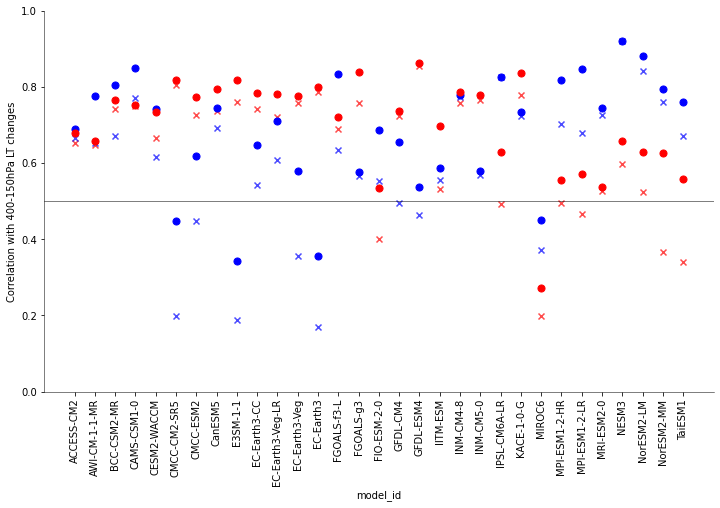

In [41]:
fig,ax = plt.subplots(1,1,figsize=(12,7),facecolor="white",sharex=True)

corrs_DJF_diff.sel(epsilon_pre=0.1,epsilon_wind=0.1).plot.scatter(x="model_id",y="400_150_thick",ax=ax,color="red",marker="x",alpha=0.7)
corrs_JJA_diff.sel(epsilon_pre=0.1,epsilon_wind=0.1).plot.scatter(x="model_id",y="400_150_thick",ax=ax,color="blue",marker="x",alpha=0.7)

max_corr_JJA_diff.plot.scatter(x="model_id",y="400_150_thick",ax=ax,color="blue",s=50)
max_corr_DJF_diff.plot.scatter(x="model_id",y="400_150_thick",ax=ax,color="red",s=50)

plt.xticks(rotation=90)
metcalc.remove_axes(ax)
ax.set_title("")
ax.set_ylim(0,1)
ax.axhline(y=0.5,color="black",linewidth=0.5)
ax.axhline(y=0,color="black",linewidth=0.5)
ax.set_ylabel("Correlation with 400-150hPa LT changes")


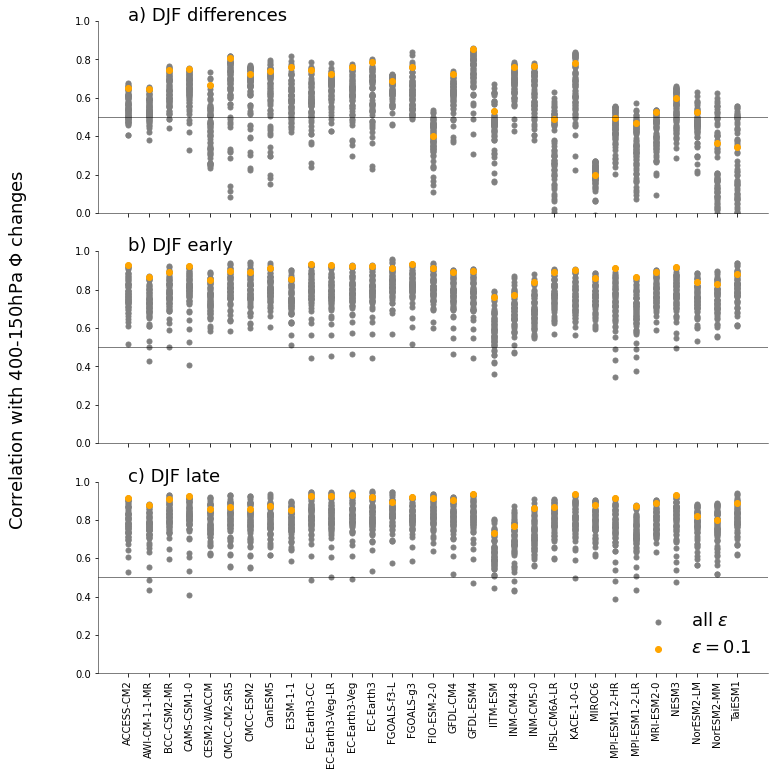

In [42]:
fig,axes = plt.subplots(3,1,figsize=(12,12),facecolor="white",sharex=True)

ax=axes[0]
corrs_DJF_diff_no_zc.plot.scatter(x="model_id",y="400_150_thick",ax=ax,color="grey",s=25)
corrs_DJF_diff_no_zc.sel(epsilon_pre=0.1,epsilon_wind=0.1).plot.scatter(x="model_id",y="400_150_thick",ax=ax,color="orange")
metcalc.remove_axes(ax)
ax.set_title("")
ax.set_ylim(0,1)
ax.axhline(y=0.5,color="black",linewidth=0.5)
ax.axhline(y=0,color="black",linewidth=0.5)
ax.set_ylabel("")
ax.set_xlabel("")
ax.text(corrs_DJF_diff.model_id.values[0],1,"a) DJF differences",size=18)

ax=axes[1]
corrs_DJF_early_no_zc.plot.scatter(x="model_id",y="400_150_thick",ax=ax,color="grey",s=25)
corrs_DJF_early_no_zc.sel(epsilon_pre=0.1,epsilon_wind=0.1).plot.scatter(x="model_id",y="400_150_thick",ax=ax,color="orange")
metcalc.remove_axes(ax)
ax.set_title("")
ax.set_ylim(0,1)
ax.axhline(y=0.5,color="black",linewidth=0.5)
ax.axhline(y=0,color="black",linewidth=0.5)
ax.set_ylabel("")
ax.set_xlabel("")
ax.text(corrs_DJF_diff.model_id.values[0],1,"b) DJF early",size=18)


ax=axes[2]
corrs_DJF_late_no_zc.plot.scatter(x="model_id",y="400_150_thick",ax=ax,color="grey",s=25)
corrs_DJF_late_no_zc.sel(epsilon_pre=0.1,epsilon_wind=0.1).plot.scatter(x="model_id",y="400_150_thick",ax=ax,color="orange")
plt.xticks(rotation=90)
metcalc.remove_axes(ax)
ax.set_title("")
ax.set_ylim(0,1)
ax.axhline(y=0.5,color="black",linewidth=0.5)
ax.axhline(y=0,color="black",linewidth=0.5)
ax.set_ylabel("")
ax.set_xlabel("")
ax.text(corrs_DJF_diff.model_id.values[0],1,"c) DJF late",size=18)
ax.legend(["all $\epsilon$","$\epsilon = 0.1$"],loc="lower right",frameon=False,prop={'size': 18})

fig.supylabel("Correlation with 400-150hPa $\Phi$ changes", size=18)


plt.savefig('/home/m/m300577/plots/paper2/scatter_corr_cmip_DJF.png', dpi=600,bbox_inches='tight')


Text(ACCESS-CM2, 1, 'c) JJA late')

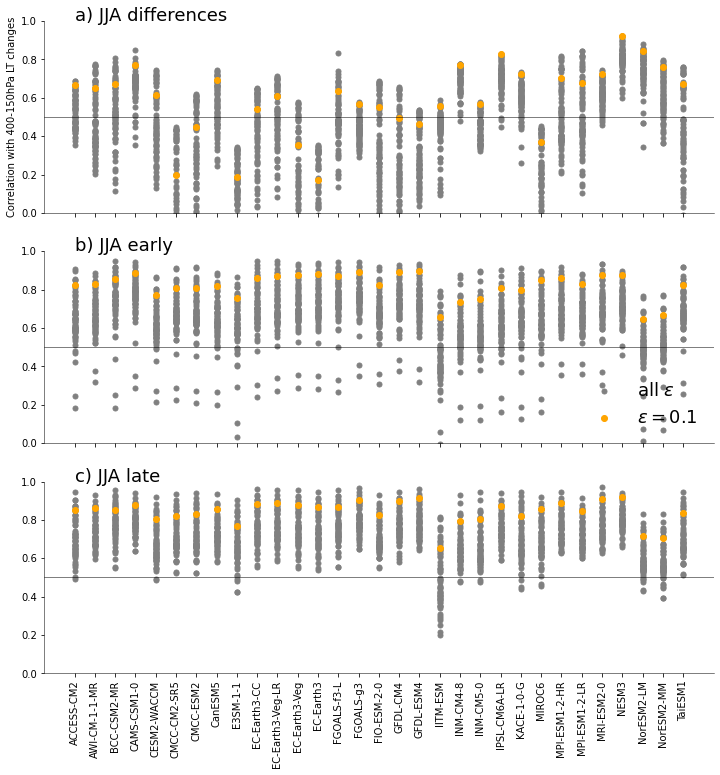

In [37]:
fig,axes = plt.subplots(3,1,figsize=(12,12),facecolor="white",sharex=True)

ax=axes[0]
corrs_JJA_diff.plot.scatter(x="model_id",y="400_150_thick",ax=ax,color="grey",s=25)
corrs_JJA_diff.sel(epsilon_pre=0.1,epsilon_wind=0.1).plot.scatter(x="model_id",y="400_150_thick",ax=ax,color="orange")
metcalc.remove_axes(ax)
ax.set_title("")
ax.set_ylim(0,1)
ax.axhline(y=0.5,color="black",linewidth=0.5)
ax.axhline(y=0,color="black",linewidth=0.5)
ax.set_ylabel("Correlation with 400-150hPa LT changes")
ax.set_xlabel("")
ax.text(corrs_JJA_diff.model_id.values[0],1,"a) JJA differences",size=18)

ax=axes[1]
corrs_JJA_early.plot.scatter(x="model_id",y="400_150_thick",ax=ax,color="grey",s=25)
corrs_JJA_early.sel(epsilon_pre=0.1,epsilon_wind=0.1).plot.scatter(x="model_id",y="400_150_thick",ax=ax,color="orange")
metcalc.remove_axes(ax)
ax.set_title("")
ax.set_ylim(0,1)
ax.axhline(y=0.5,color="black",linewidth=0.5)
ax.axhline(y=0,color="black",linewidth=0.5)
ax.set_ylabel("")
ax.set_xlabel("")
ax.text(corrs_JJA_diff.model_id.values[0],1,"b) JJA early",size=18)
ax.legend(["all $\epsilon$","$\epsilon = 0.1$"],loc="lower right",frameon=False,prop={'size': 18})

ax=axes[2]
corrs_JJA_late.plot.scatter(x="model_id",y="400_150_thick",ax=ax,color="grey",s=25)
corrs_JJA_late.sel(epsilon_pre=0.1,epsilon_wind=0.1).plot.scatter(x="model_id",y="400_150_thick",ax=ax,color="orange")

plt.xticks(rotation=90)
metcalc.remove_axes(ax)
ax.set_title("")
ax.set_ylim(0,1)
ax.axhline(y=0.5,color="black",linewidth=0.5)
ax.axhline(y=0,color="black",linewidth=0.5)
ax.set_ylabel("")
ax.set_xlabel("")
ax.text(corrs_JJA_diff.model_id.values[0],1,"c) JJA late",size=18)


#plt.savefig('/home/m/m300577/plots/paper2/scatter_corr_cmip.png', dpi=600,bbox_inches='tight')


# Histogram Plots

## 400-150

### DJF

In [43]:
def numpy_to_string(array) :
    return [item for item in array.astype(str)]

In [44]:
epsilons_pre_value = numpy_to_string(frequencies_DJF_early.epsilon_pre.values)
epsilons_wind_value = numpy_to_string(frequencies_DJF_early.epsilon_wind.values)
epsilons_pre_time = frequencies_DJF_early.diss_time_ep.values
epsilons_wind_time = frequencies_DJF_early.diss_time_ew.values

In [45]:
epsilons_pre_value

['0.0', '0.01', '0.02', '0.05', '0.1', '0.2', '0.3', '0.5', '0.7', '1.5']

In [46]:
epsilons_pre_time

array(['inf\nzc', '20d', '10d', '5d', '2d', '1d', '18h', '11h', '8h',
       '4h'], dtype='<U6')

In [47]:
epsilons_pre = []
for i,e in enumerate(epsilons_pre_value) :
    epsilons_pre.append(e+ "\n" + epsilons_pre_time[i])
epsilons_wind = []
for i,e in enumerate(epsilons_wind_value) :
    epsilons_wind.append(e+ "\n" + epsilons_wind_time[i])

In [48]:
epsilons_pre

['0.0\ninf\nzc',
 '0.01\n20d',
 '0.02\n10d',
 '0.05\n5d',
 '0.1\n2d',
 '0.2\n1d',
 '0.3\n18h',
 '0.5\n11h',
 '0.7\n8h',
 '1.5\n4h']

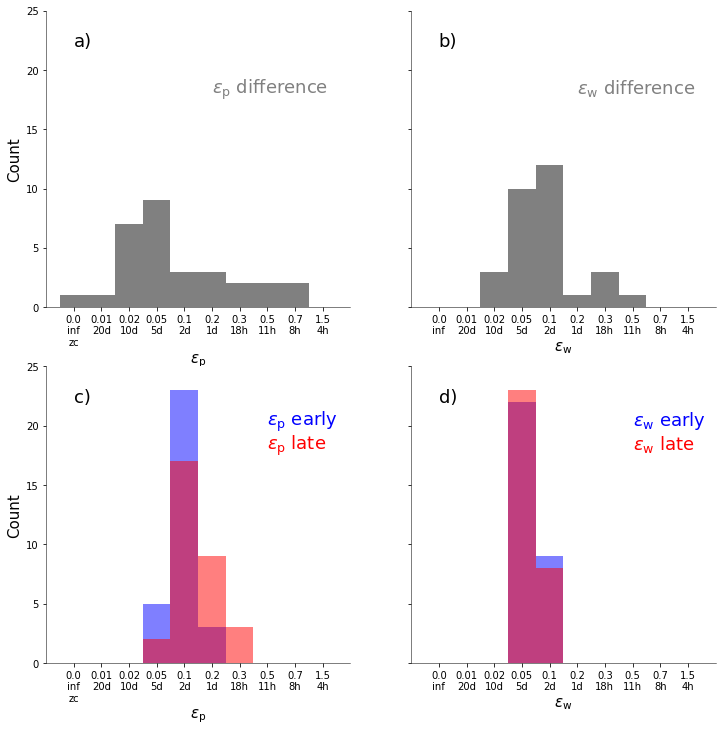

In [49]:
fig,axes = plt.subplots(2,2, figsize=(12, 12),facecolor="white",sharey=True)


ax=axes[0,0]
pre_dist_diff = frequencies_DJF_diff.sum("epsilon_wind").values
ax.bar(epsilons_pre,pre_dist_diff,color="grey",fill=True,width=1)
ax.set_ylim(0,25)
metcalc.remove_axes(ax)
ax.text(epsilons_pre[-5],18,"$\epsilon_\mathrm{p}$ difference",size=18,color="grey")
ax.text(epsilons_pre[0],22,"a)",size=18,color="black")

ax.set_xlabel("$\epsilon_\mathrm{p}$",size=15)
ax.set_ylabel("Count",size=15)

ax=axes[0,1]
wind_dist_diff = frequencies_DJF_diff.sum("epsilon_pre").values
ax.bar(epsilons_wind,wind_dist_diff,color="grey",fill=True,width=1)
metcalc.remove_axes(ax)
ax.set_ylim(0,25)
ax.text(epsilons_pre[-5],18,"$\epsilon_\mathrm{w}$ difference",size=18,color="grey")
ax.text(epsilons_wind[0],22,"b)",size=18,color="black")
ax.set_xlabel("$\epsilon_\mathrm{w}$",size=15)

ax=axes[1,0]
pre_dist_early = frequencies_DJF_early.sum("epsilon_wind").values
ax.bar(epsilons_pre,pre_dist_early,color="blue",alpha=0.5,width=1)
pre_dist_late = frequencies_DJF_late.sum("epsilon_wind").values
ax.bar(epsilons_pre,pre_dist_late,color="red",alpha=0.5,width=1)
ax.set_ylim(0,25)
metcalc.remove_axes(ax)
ax.text(epsilons_pre[-3],20,"$\epsilon_\mathrm{p}$ early",size=18,color="blue")
ax.text(epsilons_pre[-3],18,"$\epsilon_\mathrm{p}$ late",size=18,color="red")
ax.set_xlabel("$\epsilon_\mathrm{p}$",size=15)
ax.text(epsilons_pre[0],22,"c)",size=18,color="black")
ax.set_ylabel("Count",size=15)

ax=axes[1,1]
wind_dist_early = frequencies_DJF_early.sum("epsilon_pre").values
ax.bar(epsilons_wind,wind_dist_early,color="blue",alpha=0.5,width=1)
wind_dist_late = frequencies_DJF_late.sum("epsilon_pre").values
ax.bar(epsilons_wind,wind_dist_late,color="red",alpha=0.5,width=1)
ax.set_ylim(0,25)
metcalc.remove_axes(ax)
ax.text(epsilons_pre[-3],20,"$\epsilon_\mathrm{w}$ early",size=18,color="blue")
ax.text(epsilons_pre[-3],18,"$\epsilon_\mathrm{w}$ late",size=18,color="red")
ax.set_xlabel("$\epsilon_\mathrm{w}$",size=15)
ax.text(epsilons_wind[0],22,"d)",size=18,color="black")


plt.savefig('../plots/histo_corr_cmip_DJF.png', dpi=600,bbox_inches='tight')


(0.0, 25.0)

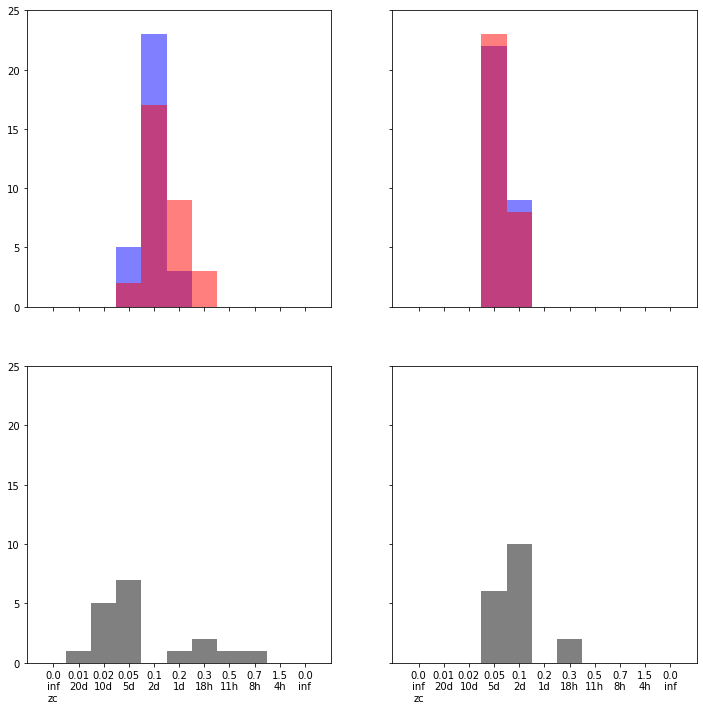

In [50]:
fig,axes = plt.subplots(2,2, figsize=(12, 12),facecolor="white",sharex=True,sharey=True)


ax=axes[0,0]
pre_dist_early = frequencies_DJF_early_07.sum("epsilon_wind").values
ax.bar(epsilons_pre,pre_dist_early,color="blue",alpha=0.5,width=1)
pre_dist_late = frequencies_DJF_late_07.sum("epsilon_wind").values
ax.bar(epsilons_pre,pre_dist_late,color="red",alpha=0.5,width=1)
ax.set_ylim(0,25)

ax=axes[0,1]
wind_dist_early = frequencies_DJF_early_07.sum("epsilon_pre").values
ax.bar(epsilons_wind,wind_dist_early,color="blue",alpha=0.5,width=1)
wind_dist_late = frequencies_DJF_late_07.sum("epsilon_pre").values
ax.bar(epsilons_wind,wind_dist_late,color="red",alpha=0.5,width=1)
ax.set_ylim(0,25)

ax=axes[1,0]
pre_dist_diff = frequencies_DJF_diff_07.sum("epsilon_wind").values
ax.bar(epsilons_pre,pre_dist_diff,color="grey",fill=True,width=1)
ax.set_ylim(0,25)

ax=axes[1,1]
wind_dist_diff = frequencies_DJF_diff_07.sum("epsilon_pre").values
ax.bar(epsilons_wind,wind_dist_diff,color="grey",fill=True,width=1)

ax.set_ylim(0,25)



### JJA

(0.0, 32.0)

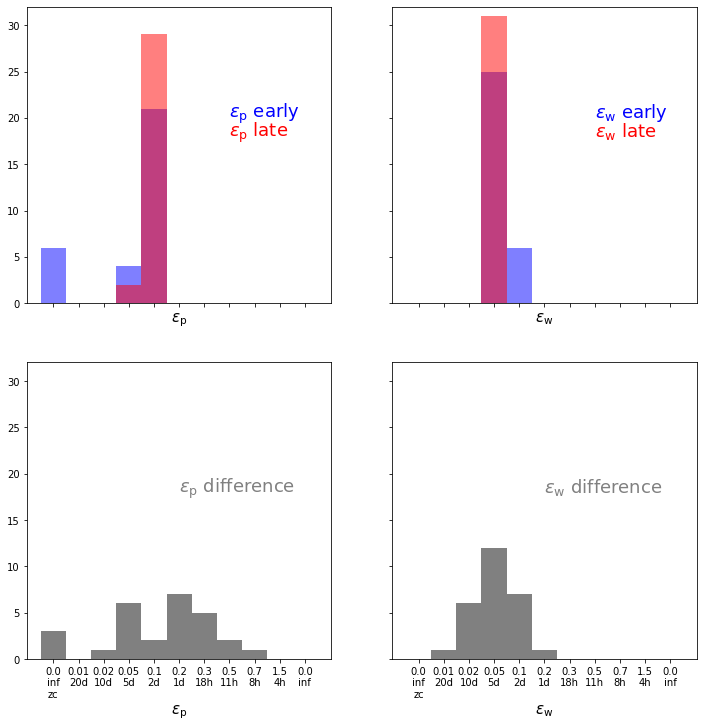

In [51]:
fig,axes = plt.subplots(2,2, figsize=(12, 12),facecolor="white",sharex=True,sharey=True)


ax=axes[0,0]
pre_dist_early = frequencies_JJA_early.sum("epsilon_wind").values
ax.bar(epsilons_pre,pre_dist_early,color="blue",alpha=0.5,width=1)
pre_dist_late = frequencies_JJA_late.sum("epsilon_wind").values
ax.bar(epsilons_pre,pre_dist_late,color="red",alpha=0.5,width=1)
ax.set_ylim(0,32)
ax.set_xlabel("$\epsilon_\mathrm{p}$",size=15)
ax.text(epsilons_pre[-3],20,"$\epsilon_\mathrm{p}$ early",size=18,color="blue")
ax.text(epsilons_pre[-3],18,"$\epsilon_\mathrm{p}$ late",size=18,color="red")

ax=axes[0,1]
wind_dist_early = frequencies_JJA_early.sum("epsilon_pre").values
ax.bar(epsilons_wind,wind_dist_early,color="blue",alpha=0.5,width=1)
wind_dist_late = frequencies_JJA_late.sum("epsilon_pre").values
ax.bar(epsilons_wind,wind_dist_late,color="red",alpha=0.5,width=1)
ax.set_ylim(0,32)
ax.set_xlabel("$\epsilon_\mathrm{w}$",size=15)
ax.text(epsilons_pre[-3],20,"$\epsilon_\mathrm{w}$ early",size=18,color="blue")
ax.text(epsilons_pre[-3],18,"$\epsilon_\mathrm{w}$ late",size=18,color="red")

ax=axes[1,0]
pre_dist_diff = frequencies_JJA_diff.sum("epsilon_wind").values
ax.bar(epsilons_pre,pre_dist_diff,color="grey",fill=True,width=1)
ax.set_ylim(0,32)
ax.set_xlabel("$\epsilon_\mathrm{p}$",size=15)
ax.text(epsilons_pre[-5],18,"$\epsilon_\mathrm{p}$ difference",size=18,color="grey")


ax=axes[1,1]
wind_dist_diff = frequencies_JJA_diff.sum("epsilon_pre").values
ax.bar(epsilons_wind,wind_dist_diff,color="grey",fill=True,width=1)
ax.set_xlabel("$\epsilon_\mathrm{w}$",size=15)
ax.text(epsilons_pre[-5],18,"$\epsilon_\mathrm{w}$ difference",size=18,color="grey")

ax.set_ylim(0,32)



Text(0.0
inf, 22, 'd)')

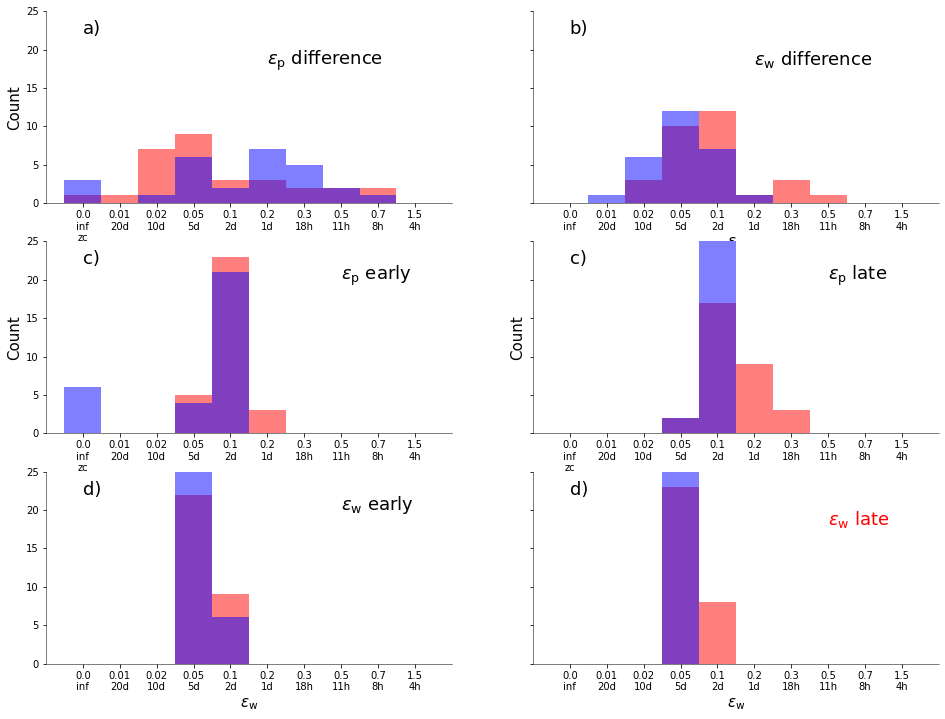

In [54]:
fig,axes = plt.subplots(3,2, figsize=(16, 12),facecolor="white",sharey=True)


ax=axes[0,0]
pre_dist_diff = frequencies_DJF_diff.sum("epsilon_wind").values
ax.bar(epsilons_pre,pre_dist_diff,color="red",fill=True,width=1,alpha=0.5)
pre_dist_diff = frequencies_JJA_diff.sum("epsilon_wind").values
ax.bar(epsilons_pre,pre_dist_diff,color="blue",fill=True,width=1,alpha=0.5)
ax.set_ylim(0,25)
metcalc.remove_axes(ax)
ax.text(epsilons_pre[-5],18,"$\epsilon_\mathrm{p}$ difference",size=18,color="black")
ax.text(epsilons_pre[0],22,"a)",size=18,color="black")

ax.set_xlabel("$\epsilon_\mathrm{p}$",size=15)
ax.set_ylabel("Count",size=15)

ax=axes[0,1]
wind_dist_diff = frequencies_DJF_diff.sum("epsilon_pre").values
ax.bar(epsilons_wind,wind_dist_diff,color="red",fill=True,width=1,alpha=0.5)
wind_dist_diff = frequencies_JJA_diff.sum("epsilon_pre").values
ax.bar(epsilons_wind,wind_dist_diff,color="blue",fill=True,width=1,alpha=0.5)
metcalc.remove_axes(ax)
ax.set_ylim(0,25)
ax.text(epsilons_pre[-5],18,"$\epsilon_\mathrm{w}$ difference",size=18,color="black")
ax.text(epsilons_wind[0],22,"b)",size=18,color="black")
ax.set_xlabel("$\epsilon_\mathrm{w}$",size=15)

ax=axes[1,0]
pre_dist_early = frequencies_DJF_early.sum("epsilon_wind").values
ax.bar(epsilons_pre,pre_dist_early,color="red",alpha=0.5,width=1)
pre_dist_early = frequencies_JJA_early.sum("epsilon_wind").values
ax.bar(epsilons_pre,pre_dist_early,color="blue",alpha=0.5,width=1)
ax.set_ylim(0,25)
metcalc.remove_axes(ax)
ax.text(epsilons_pre[-3],20,"$\epsilon_\mathrm{p}$ early",size=18,color="black")
ax.set_xlabel("$\epsilon_\mathrm{p}$",size=15)
ax.text(epsilons_pre[0],22,"c)",size=18,color="black")
ax.set_ylabel("Count",size=15)


ax=axes[1,1]
pre_dist_late = frequencies_DJF_late.sum("epsilon_wind").values
ax.bar(epsilons_pre,pre_dist_late,color="red",alpha=0.5,width=1)
pre_dist_late = frequencies_JJA_late.sum("epsilon_wind").values
ax.bar(epsilons_pre,pre_dist_late,color="blue",alpha=0.5,width=1)
ax.set_ylim(0,25)
metcalc.remove_axes(ax)
ax.text(epsilons_pre[-3],20,"$\epsilon_\mathrm{p}$ late",size=18,color="black")
ax.set_xlabel("$\epsilon_\mathrm{p}$",size=15)
ax.text(epsilons_pre[0],22,"c)",size=18,color="black")
ax.set_ylabel("Count",size=15)

ax=axes[2,0]
wind_dist_early = frequencies_DJF_early.sum("epsilon_pre").values
ax.bar(epsilons_wind,wind_dist_early,color="red",alpha=0.5,width=1)
wind_dist_early = frequencies_JJA_early.sum("epsilon_pre").values
ax.bar(epsilons_wind,wind_dist_early,color="blue",alpha=0.5,width=1)
ax.set_ylim(0,25)
metcalc.remove_axes(ax)
ax.text(epsilons_pre[-3],20,"$\epsilon_\mathrm{w}$ early",size=18,color="black")
ax.set_xlabel("$\epsilon_\mathrm{w}$",size=15)
ax.text(epsilons_wind[0],22,"w)",size=18,color="black")


ax=axes[2,1]
wind_dist_late = frequencies_DJF_late.sum("epsilon_pre").values
ax.bar(epsilons_wind,wind_dist_late,color="red",alpha=0.5,width=1)
wind_dist_late = frequencies_JJA_late.sum("epsilon_pre").values
ax.bar(epsilons_wind,wind_dist_late,color="blue",alpha=0.5,width=1)
ax.set_ylim(0,25)
metcalc.remove_axes(ax)
ax.text(epsilons_pre[-3],18,"$\epsilon_\mathrm{w}$ late",size=18,color="red")
ax.set_xlabel("$\epsilon_\mathrm{w}$",size=15)
ax.text(epsilons_wind[0],22,"f)",size=18,color="black")




### MI

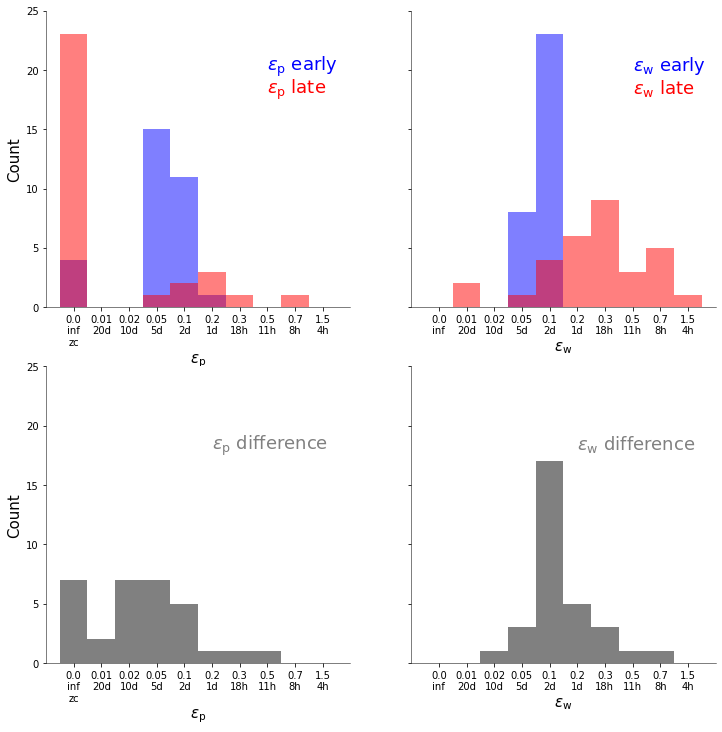

In [83]:
fig,axes = plt.subplots(2,2, figsize=(12, 12),facecolor="white",sharey=True)

ax=axes[0,0]
pre_dist_early = frequencies_DJF_early_MI.sum("epsilon_wind").values
ax.bar(epsilons_pre,pre_dist_early,color="blue",alpha=0.5,width=1)
pre_dist_late = frequencies_DJF_late_MI.sum("epsilon_wind").values
ax.bar(epsilons_pre,pre_dist_late,color="red",alpha=0.5,width=1)
ax.set_ylim(0,25)
metcalc.remove_axes(ax)
ax.text(epsilons_pre[-3],20,"$\epsilon_\mathrm{p}$ early",size=18,color="blue")
ax.text(epsilons_pre[-3],18,"$\epsilon_\mathrm{p}$ late",size=18,color="red")
ax.set_xlabel("$\epsilon_\mathrm{p}$",size=15)
ax.set_ylabel("Count",size=15)


ax=axes[0,1]
wind_dist_early = frequencies_DJF_early_MI.sum("epsilon_pre").values
ax.bar(epsilons_wind,wind_dist_early,color="blue",alpha=0.5,width=1)
wind_dist_late = frequencies_DJF_late_MI.sum("epsilon_pre").values
ax.bar(epsilons_wind,wind_dist_late,color="red",alpha=0.5,width=1)
ax.set_ylim(0,25)
metcalc.remove_axes(ax)
ax.text(epsilons_pre[-3],20,"$\epsilon_\mathrm{w}$ early",size=18,color="blue")
ax.text(epsilons_pre[-3],18,"$\epsilon_\mathrm{w}$ late",size=18,color="red")
ax.set_xlabel("$\epsilon_\mathrm{w}$",size=15)

ax=axes[1,0]
pre_dist_diff = frequencies_DJF_diff_MI.sum("epsilon_wind").values
ax.bar(epsilons_pre,pre_dist_diff,color="grey",fill=True,width=1)
ax.set_ylim(0,25)
metcalc.remove_axes(ax)
ax.text(epsilons_pre[-5],18,"$\epsilon_\mathrm{p}$ difference",size=18,color="grey")
ax.set_xlabel("$\epsilon_\mathrm{p}$",size=15)
ax.set_ylabel("Count",size=15)


ax=axes[1,1]
wind_dist_diff = frequencies_DJF_diff_MI.sum("epsilon_pre").values
ax.bar(epsilons_wind,wind_dist_diff,color="grey",fill=True,width=1)
metcalc.remove_axes(ax)
ax.set_ylim(0,25)
ax.text(epsilons_pre[-5],18,"$\epsilon_\mathrm{w}$ difference",size=18,color="grey")
ax.set_xlabel("$\epsilon_\mathrm{w}$",size=15)


Text(0.5, 0, '$\\epsilon_\\mathrm{w}$')

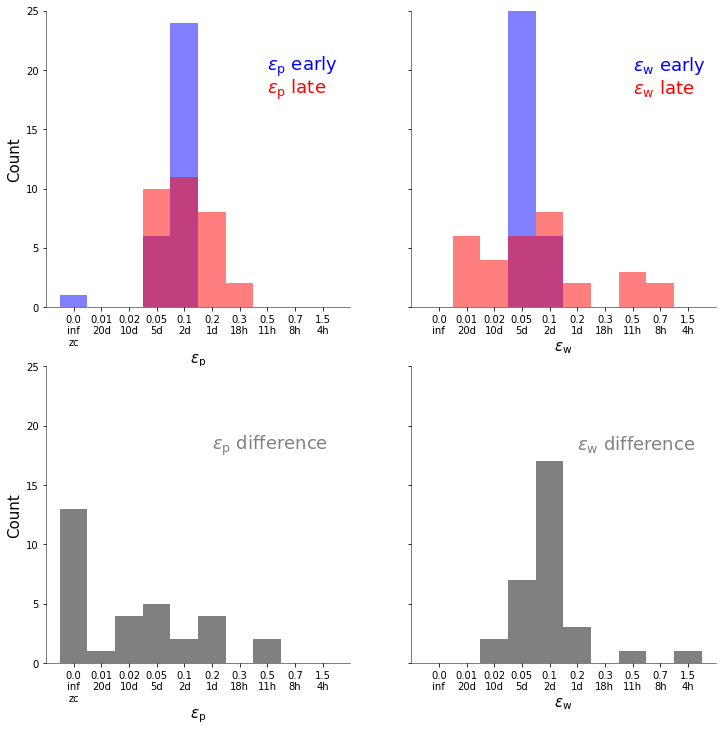

In [84]:
fig,axes = plt.subplots(2,2, figsize=(12, 12),facecolor="white",sharey=True)

ax=axes[0,0]
pre_dist_early = frequencies_JJA_early_MI.sum("epsilon_wind").values
ax.bar(epsilons_pre,pre_dist_early,color="blue",alpha=0.5,width=1)
pre_dist_late = frequencies_JJA_late_MI.sum("epsilon_wind").values
ax.bar(epsilons_pre,pre_dist_late,color="red",alpha=0.5,width=1)
ax.set_ylim(0,25)
metcalc.remove_axes(ax)
ax.text(epsilons_pre[-3],20,"$\epsilon_\mathrm{p}$ early",size=18,color="blue")
ax.text(epsilons_pre[-3],18,"$\epsilon_\mathrm{p}$ late",size=18,color="red")
ax.set_xlabel("$\epsilon_\mathrm{p}$",size=15)
ax.set_ylabel("Count",size=15)


ax=axes[0,1]
wind_dist_early = frequencies_JJA_early_MI.sum("epsilon_pre").values
ax.bar(epsilons_wind,wind_dist_early,color="blue",alpha=0.5,width=1)
wind_dist_late = frequencies_JJA_late_MI.sum("epsilon_pre").values
ax.bar(epsilons_wind,wind_dist_late,color="red",alpha=0.5,width=1)
ax.set_ylim(0,25)
metcalc.remove_axes(ax)
ax.text(epsilons_pre[-3],20,"$\epsilon_\mathrm{w}$ early",size=18,color="blue")
ax.text(epsilons_pre[-3],18,"$\epsilon_\mathrm{w}$ late",size=18,color="red")
ax.set_xlabel("$\epsilon_\mathrm{w}$",size=15)

ax=axes[1,0]
pre_dist_diff = frequencies_JJA_diff_MI.sum("epsilon_wind").values
ax.bar(epsilons_pre,pre_dist_diff,color="grey",fill=True,width=1)
ax.set_ylim(0,25)
metcalc.remove_axes(ax)
ax.text(epsilons_pre[-5],18,"$\epsilon_\mathrm{p}$ difference",size=18,color="grey")
ax.set_xlabel("$\epsilon_\mathrm{p}$",size=15)
ax.set_ylabel("Count",size=15)


ax=axes[1,1]
wind_dist_diff = frequencies_JJA_diff_MI.sum("epsilon_pre").values
ax.bar(epsilons_wind,wind_dist_diff,color="grey",fill=True,width=1)
metcalc.remove_axes(ax)
ax.set_ylim(0,25)
ax.text(epsilons_pre[-5],18,"$\epsilon_\mathrm{w}$ difference",size=18,color="grey")
ax.set_xlabel("$\epsilon_\mathrm{w}$",size=15)



## Change in eptimal epsilons per model

(-0.5, 0.5)

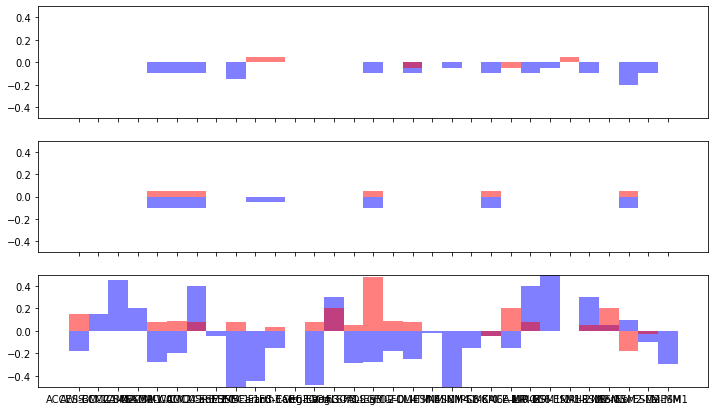

In [52]:
fig,axes = plt.subplots(3,1,figsize=(12,7),facecolor="white",sharex=True)

ax=axes[0]
ax.title("Change due to warming DJF")
ax.bar(corrs_DJF_early.model_id.values,change_ep_warming_DJF,color="blue",alpha=0.5,width=1)
ax.bar(corrs_DJF_early.model_id.values,change_ew_warming_DJF,color="red",alpha=0.5,width=1)
ax.set_ylim(-0.5,0.5)

ax=axes[1]
ax.title("Change due to warming JJA")
ax.bar(corrs_JJA_early.model_id.values,change_ep_warming_JJA,color="blue",alpha=0.5,width=1)
ax.bar(corrs_JJA_early.model_id.values,change_ew_warming_JJA,color="red",alpha=0.5,width=1)
ax.set_ylim(-0.5,0.5)

ax=axes[2]
ax.title("Change between seasons")
ax.bar(corrs_JJA_early.model_id.values,change_ep_season,color="blue",alpha=0.5,width=1)
ax.bar(corrs_JJA_early.model_id.values,change_ew_season,color="red",alpha=0.5,width=1)
ax.set_ylim(-0.5,0.5)
